In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

2025-11-03 16:15:29.200600: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762186529.431883      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762186529.502139      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
#read images folders (train, test, validation)
data_path = '/kaggle/input/wheat-leaf-dataset/wheat_leaf'

In [4]:
images_class = os.listdir('/kaggle/input/wheat-leaf-dataset/wheat_leaf')
images_class

['stripe_rust', 'septoria', 'Healthy']

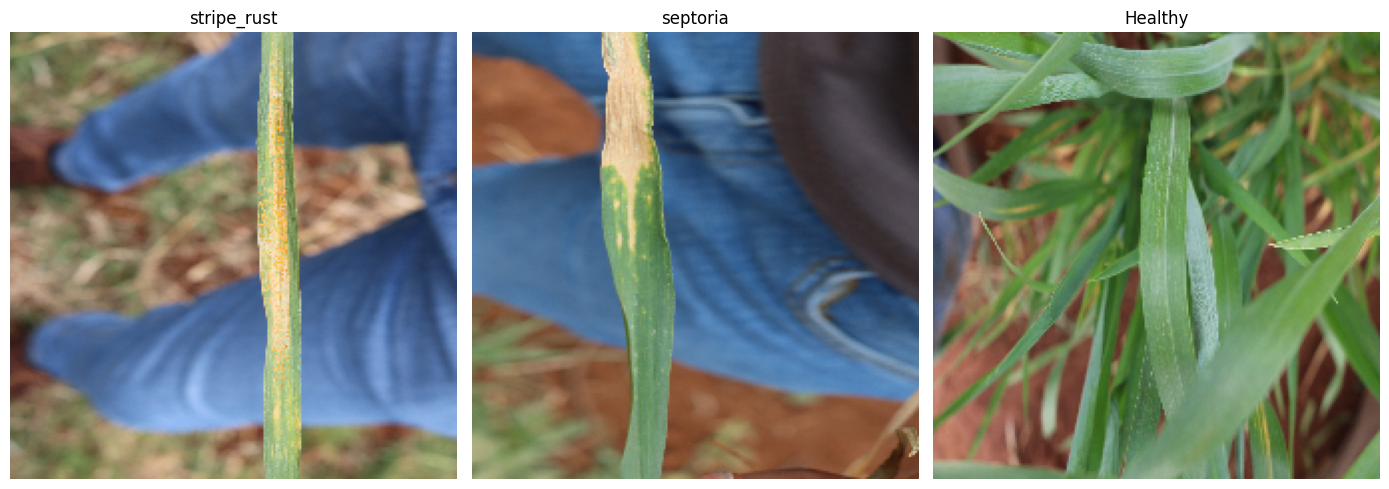

In [5]:
def plot_images(images_class):
    plt.figure(figsize=(14, 6))
    
    for i, category in enumerate(images_class):
        image_path = os.path.join(data_path, category)
        images_in_folder = os.listdir(image_path)
        
        if len(images_in_folder) == 0:
            continue
        
        first_image = images_in_folder[0]
        first_image_path = os.path.join(image_path, first_image)
        
        img = image.load_img(first_image_path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0
        
        plt.subplot(1, len(images_class), i + 1)
        plt.imshow(img_array)
        plt.title(category)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# استدعاء الدالة
plot_images(images_class)

In [6]:
base_dir = '/kaggle/working/split_wheat_leaf'
os.makedirs(base_dir, exist_ok=True)
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

for d in [train_dir, val_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

for category in images_class:
    src_folder = os.path.join(data_path, category)
    images = os.listdir(src_folder)

    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)


    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for folder, img_list in zip([train_dir, val_dir, test_dir], [train_imgs, val_imgs, test_imgs]):
        dest = os.path.join(folder, category)
        os.makedirs(dest, exist_ok=True)
        for img_name in img_list:
            shutil.copy(os.path.join(src_folder, img_name), os.path.join(dest, img_name))


In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.3,
    horizontal_flip=True
)

In [9]:
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)


Found 283 images belonging to 3 classes.


In [11]:

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 61 images belonging to 3 classes.


In [12]:
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 63 images belonging to 3 classes.


In [13]:
model = Sequential([
    Conv2D(32, (3,3), padding='same', input_shape=(150,150,3)),
    Activation('relu'),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), padding='same'),
    Activation('relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), padding='same'),
    Activation('relu'),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), padding='same'),
    Activation('relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128),
    Activation('relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1762186671.511498      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,043,139 (11.61 MB)

 Trainable params: 3,043,139 (11.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy']) 

In [19]:
model_history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator 
)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 58s 7s/step - accuracy: 0.8613 - loss: 0.3369 - val_accuracy: 0.8689 - val_loss: 0.2300
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.8563 - loss: 0.3494 - val_accuracy: 0.9180 - val_loss: 0.2097
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.8388 - loss: 0.3981 - val_accuracy: 0.9672 - val_loss: 0.1816
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 0.7980 - loss: 0.4437 - val_accuracy: 0.9508 - val_loss: 0.1870
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.8032 - loss: 0.3905 - val_accuracy: 0.9508 - val_loss: 0.1390
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.8498 - loss: 0.3984 - val_accuracy: 0.9180 - val_loss: 0.2069
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 0.8827 - loss: 0.2549 - val_accuracy: 0.9344 - val_loss: 0.1449
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.8952 - loss: 0.2880 - val_accuracy: 0.9672 - val_loss: 0.1295
Epoch 9/

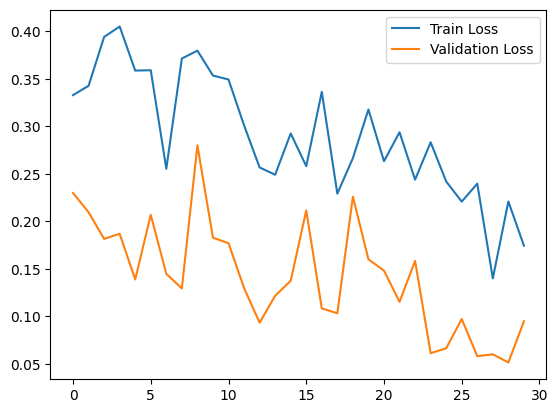

In [20]:
plt.plot(model_history.history['loss'], label = 'Train Loss')
plt.plot(model_history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()

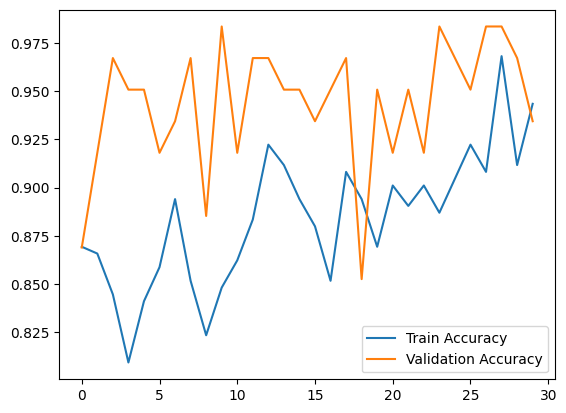

In [21]:
plt.plot(model_history.history['accuracy'], label = 'Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.show()

In [22]:
model.evaluate(test_generator)

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.9684 - loss: 0.1280


[0.12863196432590485, 0.9682539701461792]

In [23]:
test_generator.reset()  # مهم جداً قبل التنبؤ
pred = model.predict(test_generator, verbose=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step


In [ ]:
y_pred = np.argmax(pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys()) 

In [26]:
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

# 🔹 Test Metrics

In [ ]:
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")


🔹 **Test Metrics**
Accuracy:  0.9683
Precision: 0.9692
Recall:    0.9683
F1 Score:  0.9682


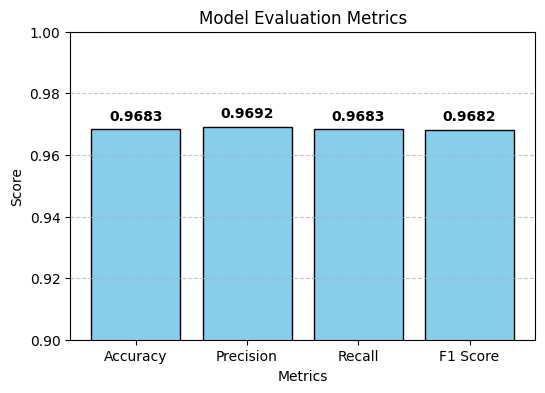

In [39]:
# Metrics values
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [0.9683, 0.9692, 0.9683, 0.9682]

# Plot bar chart
plt.figure(figsize=(6,4))
bars = plt.bar(metrics, values, color='skyblue', edgecolor='black')
plt.ylim(0.9, 1.0)
plt.title("Model Evaluation Metrics")
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.002, f"{yval:.4f}", 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.show()


# 🧾 Classification Report

In [ ]:
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


📋 Classification Report:
              precision    recall  f1-score   support

     Healthy       0.94      1.00      0.97        16
    septoria       1.00      0.93      0.97        15
 stripe_rust       0.97      0.97      0.97        32

    accuracy                           0.97        63
   macro avg       0.97      0.97      0.97        63
weighted avg       0.97      0.97      0.97        63



# 📉 Confusion Matrix

In [ ]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[16  0  0]
 [ 0 14  1]
 [ 1  0 31]]


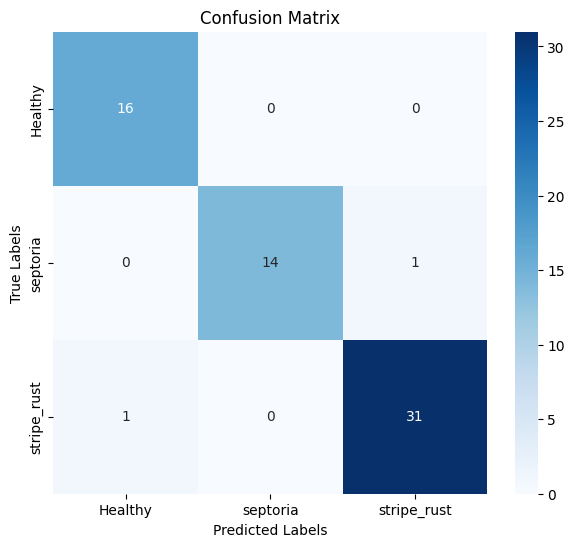

In [ ]:
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [35]:
#save cnnn model
model.save('wheat leaf model.h5')

In [36]:
#load h5 model
from tensorflow.keras.models import load_model
model = load_model('wheat leaf model.h5')